# Wasserstein - GAN and Gradient Penalty

The implementation based on DCGAN from "animefaces_DCGAN.ipynb" and the following paper:

__[Martin Arjovsky, Soumith Chintala, Léon Bottou. Wasserstein GAN. 2017](https://arxiv.org/abs/1701.07875)__

- improves stability of model training
- loss function correlate with image quality from generator images
- increase stability between discriminator and generator
- training process is more stable and less sensitive
- seeks convergence, lowering generator loss
- critic model for scores of realness or fakness, instead of discriminator

Notes:

- W-Loss function is relativ, depends on modell configuration and dataset
- W-Loss isn't usable for comparison between GANs
    
Architecture guidelines for Wasserstein GAN:

- W-Loss for generated fake images = Avearage Predicted Score
- W-Loss for real images = - Avearage Predicted Score
- linear activation in critic output layer, instead of sigmoid

## Deep Convolution Generated Adversarial Network - DCGAN

The DCGAN based on:

__[Alec Radford, Luke Metz, Soumith Chintala. Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. 2015](https://arxiv.org/abs/1511.06434)__

The paper describes how to increase the stability of GANs using best practices. It took a lot of extensive empirical time to find the information in the mentioned paper.

Problems such as:

- equilibrium between Discriminator and Generator
- howto resolve issue of non-convergence

, should, according to the paper, be resolved by the following changes to the simple GAN:

Architecture guidelines for stable Deep Convolutional GANs
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.


In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import json
import glob
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets
from torchsummary import summary
from IPython.display import HTML, clear_output
from ipywidgets import HBox, VBox, Textarea, Button


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    #img_grid = vutils.make_grid(images[0].to(self._device)[0:56])
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.002)

Random Seed:  999


## Inputs
Parameter definition:

- __dataroot__ - Root directory for dataset
- __workers__ - Number of workers for dataloader
- __batch_size__ - Batch size during training
- __image_size__ - Spatial size of training images. All images will be resized to this size using a transformer
- __nc__ - Number of channels in the training images, RGB=3
- __nz__ - Size of z latent vector (i.e. size of generator input)
- __ngf__ - Size of feature maps in generator
- __ndf__ - Size of feature maps in discriminator
- __num_epochs__ - Number of training epochs
- __lr__ - Learning rate for optimizers
- __beta1__ - Beta1 hyperparam for Adam optimizers
- __ngpu__ - Number of available GPUs; 0 = CPU
- __penalty_weight__ - weight for gradient penalty

User Interface definition:

- __autosave__ - automatic model save after x epochs
- __fake_label__ - label for fakes
- __real_label__ - label for real
- __type__ - sequence/training - routine type
- __n_extra_layers_g__ - count of extra generator layers
- __n_extra_layers_d__ - count of extra discriminator layers
- __optim__ - opimizer index
- __loss_id__ - loss index
- __opt_net_struc__ - GAN type
- __is_dropout__ - use dropout layer additional
- __lipschitz__ - index of penalty or weight-limit are used (WGAN-GP)
- __to_output__ - printout every iteration
- __critic_count__ - how often should critic be trained more
- __img_per_epoch__ - one image per epoch to output (jupyter-output)
- __to_tensorboard__ - save values and images to TensorBoard
- __activation_func__ - index of used activation function (0=None, 1=Sigmoid)

The bag_of_params contains all defines of necessary parameters.

In [3]:
%run ./common/common.py

my_bop = {'dataroot': '../notebook_data',
    'workers': 2,
    'batch_size': 128,
    'image_size': 64,
    'nc': 3,
    'nz': 100,
    'ngf': 64,
    'ndf': 64,
    'num_epochs': 1,
    'activation_func': 0,
    'autosave': False,
    'ngpu': 1,
    'fake_label': 0,
    'real_label': 1,
    'penalty_weight': 0.1,
    'type': 1,
    'n_extra_layers_g': 0,
    'n_extra_layers_d': 0,
    'smooth_labels': False,
    'noisy_labels': False,
    'optim': 0,
    'loss_id': 0,
    'opt_net_struc': 0,
    'id_gen': 0,
    'id_dis': 0,
    'is_dropout': False,
    'lipschitz': 0,
    'to_output': False,
    'critic_count': 5,
    'img_per_epoch': False,
    'to_tensorboard': False}

In [4]:
#default for WGAN and WGAN-GP, not for DCGAN!
my_bop['batch_size'] = 64
my_bop['real_label'] = 1
my_bop['fake_label'] = -1
my_bop['penalty_weight'] = 0.1

## How to use

All executed tests are stored in experiment folders. One "exp" folder for each test stored under './data', e.g. './data/exp002'.

Also stored are user interface settings. They are stored separately as 'settings_config_xxx.json' in exp-folder.

    To load an interface setting go to point "Load presettings".
    Please run the cells and choose the json file from combobox and push load button.
    After that you run the selected cells and advanced.

Here you can see an overview of the experiments carried out:

|module type           |Layer     |              |Regularization|       |Activation Function|Labels       |            |             |Experiment number|                   |
|:--------------------:|:--------:|:------------:|:------------:|:-----:|:-----------------:|------------:|:-----------|:-----------:|:---------------:|:-----------------:|
|                      |conv trans|BatchNorm     |InstanceNorm  |Dropout|LRelu              |smoothing    |noisy       |WGAN-GP(adam)|WGAN(RMSprop)    |DCGAN(adam-sigmoid)|
|:--------------------:|:--------:|:------------:|:------------:|:-----:|:-----------------:|:-----------:|:-----------|:-----------:|:---------------:|:-----------------:|
|generator (tanh)      |x         |x             |              |       |x                  |             |            |all          |all              |all                |
|:--------------------:|:--------:|:------------:|:------------:|:-----:|:-----------------:|:-----------:|:-----------|:-----------:|:---------------:|:-----------------:|
|discriminator/critic  |x         |x             |              |       |x                  |             |            |             |                 |                   |
|                      |x         |x             |              |       |x                  |x            |x           |exp002       |                 |                   |
|                      |x         |x             |              |x      |x                  |             |            |exp003       |                 |                   |
|                      |x         |x             |              |x      |x                  |x            |x           |             |                 |exp004             |
||
|discriminator/critic  |x         |              |x             |       |x                  |             |            |             |exp005           |                   |
|                      |x         |              |x             |       |x                  |x            |x           |             |                 |                   |
|                      |x         |              |x             |x      |x                  |             |            |exp006       |                 |                   |
|                      |x         |              |x             |x      |x                  |x            |x           |             |                 |                   |

After loading an experiment you can start './Tensorboard.ipynb'. Please select there the exp-folder, respectively replace the folder name there and run the cell.
Now you can explore the experiment with TensorBoard.

### Load presettings

Next step load framework configurations from last prior calculations.

Get presettings from last experiments, to reproduce earlier results.

__Of course you can also choose your own settings.__

In [6]:
mylist = glob.glob('./data/exp*/settings_config*.json')
dropdown_files=widgets.Dropdown(options=mylist)
lay = {'width': '800px'}
batch_slider = widgets.IntSlider(layout=lay, value=my_bop['batch_size'], min=32, 
                                     max=256, step=32, 
                                     continuous_update=False, 
                                     description='batch-size')

def load_settings(data):
    # read file
    with open(data) as myfile:
        data=myfile.read()

    # parse file
    return json.loads(data)

def print_to_text(obj):
    # show values
    textarea.value = ''
    for elem in obj:
        textarea.value += ("{}: {}\n".format(elem,obj[elem]))
        
def to_textbox(data):
    print_to_text(load_settings(data))

settings_config = []
output = widgets.Output()
btn_adopt = Button(description='import',
                   tooltip='Click me to adopt settings from selection.')

def import_settings(sender):
    obj = load_settings(dropdown_files.value)
    settings_config = []
    output.clear_output()
    with output:
        print('start import...')
        for elem in obj:
            my_bop[elem] = obj[elem]
            if elem == 'batch_size':
                batch_slider.value = my_bop[elem]
            print("{}: {}".format(elem,my_bop[elem]))
        print('...import done')
    
textarea = Textarea(layout={'heigth': '100%'},
                                 description='settings:',
                                 disable=False)

out = widgets.interactive_output(to_textbox, {'data':dropdown_files})
left_box = VBox([dropdown_files, btn_adopt])
box_h = HBox([left_box, textarea])
box_v = VBox([batch_slider, box_h])
display(box_v, output)
btn_adopt.on_click(import_settings)


Output()

## Daten

https://www.kaggle.com/jasoncys/generate-anime-faces-with-variational-autoencoder/data

### Load Data

The Dataloader requires subdirectories in the root directory.

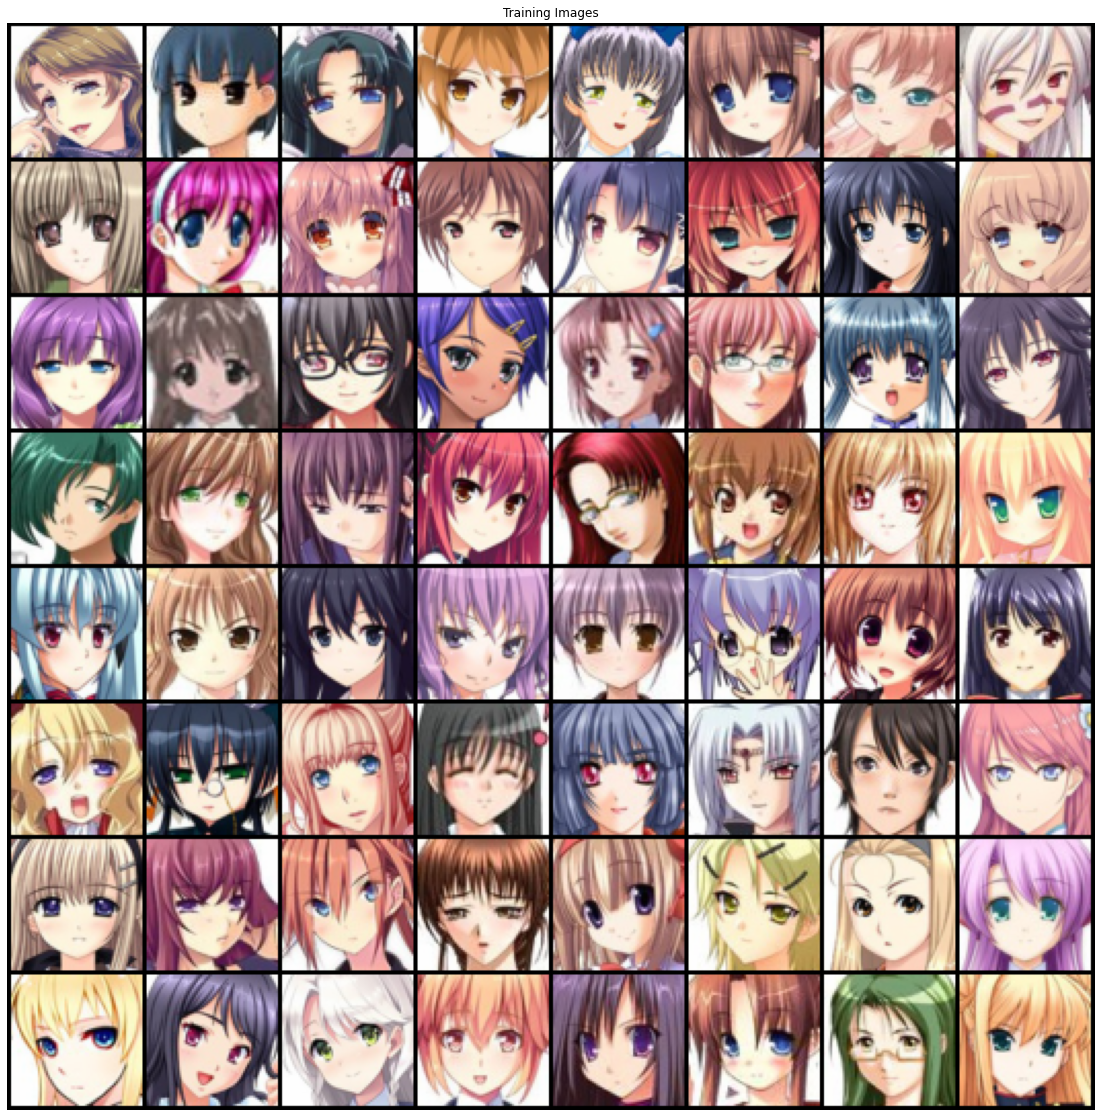

In [9]:
# Create the dataset
transform = transforms.Compose([
                               transforms.Resize(my_bop['image_size']),
                               transforms.CenterCrop(my_bop['image_size']),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

dataset = dset.ImageFolder(root='../notebook_data',
                           transform=transform)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=my_bop['batch_size'],
                                         shuffle=True, num_workers=my_bop['workers'])

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and my_bop['ngpu'] > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
nrow = 5
maxcnt = 64
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:maxcnt], padding=2, normalize=True).cpu(),(1,2,0)))

## Implementation

__[Jonathan Hui. GAN — Wasserstein GAN & WGAN-GP. 2018](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)__

__GAN__

<img src="./resources/GAN_schema.jpeg">

__WGAN__

<img src="./resources/WGAN_schema.jpeg">

### Generator

<img src="./resources/dcgan_generator.png">

Instantiate the generator and use the weights_init function

In [10]:
%run ./UI/ClassNetGenBuilder.py

my_NetGen = ClsNetGenBuilder(my_bop['image_size'], 
                             my_bop['nz'], my_bop['ngf'], 
                             my_bop['nc'], my_bop['ngpu'], 
                             device,
                             my_bop['id_gen'], my_bop['n_extra_layers_g'])
my_NetGen.draw()

Output()

### Diskriminator, Crititc model

In [8]:
%run ./UI/ClassNetDBuilder.py

my_NetD = ClsNetDBuilder(my_bop['image_size'], 
                         my_bop['ndf'],
                         my_bop['nc'], 
                         my_bop['ngpu'],
                         device,
                         my_bop['activation_func'],
                         my_bop['id_dis'],
                         my_bop['n_extra_layers_d'],
                         my_bop['is_dropout'])
my_NetD.draw()

Output()

### Optimization

Binary Cross Entropy Loss (BCELoss) Funktion:

$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]$

Recommendations of the authors:

    - Adam- Optimization for WGAN gradient penalty and DCGAN
    - RMSprop- Optimization for WGAN
    - critic weight clipping for WGAN between -0.01 and 0.01
    - learning rate 0.0002, momentum Beta1 = 0.5
    - fixed noise from Gausian distribution

In [9]:
%run ./UI/ClassSetSomeNetParamsBuilder.py

my_init_nnet_GD = ClsSetSomeNetParams(my_NetD.netD, my_NetGen.netG, my_bop['optim'], my_bop['loss_id'])
my_init_nnet_GD.draw()

Output()

## Training

- Loss_D - Discriminator loss, calculated as the sum of losses for all true and all counterfeit batches $(log(D(x))+log(D(G(z))))$.
- Loss_G - generator loss, calculated as $log(D(G(z)))$.
- $D(x)$ - the average power (over the batch) of the discriminator for the whole real batch. This should start close to 1 and theoretically converge to 0.5 as G improves. Consider why this is so.
- $D(G(z))$ - average discriminator performance for the whole fake batch. The first number is before updating D and the second number is after updating D. These numbers should start near 0 and converge to 0.5 as G improves. Think about why this is so.

In [10]:
# Witch GAN do you choose?
radio_btn_gp = widgets.RadioButtons(
            style={'description_width': 'initial'},
            options=[('DCGAN (0/1)',0),('WGAN (1/-1)',1),('WGAN-GP (1/-1)',2)],
            description='network structure:',
            disabled=False,)
radio_btn_gp.value = my_bop['opt_net_struc']
output = widgets.Output()
display(radio_btn_gp, output)

RadioButtons(description='network structure:', index=2, options=(('DCGAN (0/1)', 0), ('WGAN (1/-1)', 1), ('WGA…

Output()

__Attention button "start training" step takes a while!__, or use "load model" to load last saved model from "./data/saved_models" and move on to the next step.

In [11]:
# Training procedure
%run ./UI/ClassWidgetBuilderBase.py
%run ./UI/ClassWidgetWGAN.py
%run ./UI/ClassWidgetDCGAN.py
%run ./UI/ClassWidgetWGANGP.py

#build neuronal network structure
%run sequences/ClassDCGAN.py
%run sequences/ClassWGAN.py
%run sequences/ClassWGAN_GP.py
%run logic/ClassNetTypes.py

#%run crosscutting/ClassBaseModel.py

# transmit interface settings
my_bop['optim'] = my_init_nnet_GD.optim_id
my_bop['loss_id'] = my_init_nnet_GD.loss_id
my_bop['id_gen'] = my_NetGen.id_gen
my_bop['id_dis'] = my_NetD.id_dis
my_bop['is_dropout'] = my_NetD.is_dropout
my_bop['n_extra_layers_g'] = my_NetGen.n_extra_layers_g
my_bop['n_extra_layers_d'] = my_NetD.n_extra_layers_d
my_bop['opt_net_struc'] = radio_btn_gp.value
my_bop['activation_func'] = my_NetD.activation_func
my_bop['real_label'] = 1
my_bop['fake_label'] = -1
my_bop['workers'] = 4

# create GAN sequence
if radio_btn_gp.value <= 0:
    my_bop['real_label'] = 0
    my_bop['fake_label'] = 1
    my_bop['workers'] = 2
    my_nnet_type = ClsDCGAN(
        netD=my_init_nnet_GD.netD,
        netG=my_init_nnet_GD.netG,
        f_img_show=imshow,
        optimizerD=my_init_nnet_GD.optimizerD, optimizerG=my_init_nnet_GD.optimizerG,
        criterion=my_init_nnet_GD.criterion)
    my_concrete_builder = ClsBuilderDCGAN
elif radio_btn_gp.value == 1:
    my_nnet_type = ClsWGAN(
        netD=my_init_nnet_GD.netD,
        netG=my_init_nnet_GD.netG,
        f_img_show=imshow,
        optimizerD=my_init_nnet_GD.optimizerD, optimizerG=my_init_nnet_GD.optimizerG,
        criterion=my_init_nnet_GD.criterion)
    my_concrete_builder = ClsBuilderWGAN
elif radio_btn_gp.value == 2:
    my_nnet_type = ClsWGAN_GP(
        netD=my_init_nnet_GD.netD,
        netG=my_init_nnet_GD.netG,
        f_img_show=imshow,
        optimizerD=my_init_nnet_GD.optimizerD, optimizerG=my_init_nnet_GD.optimizerG,
        criterion=my_init_nnet_GD.criterion)
    my_concrete_builder = ClsBuilderWGANGP

my_nnet_structure = ClsNeuronalNetwork(my_nnet_type,
                        bag_of_params=my_bop,
                        device=device, 
                        dataloader=dataloader)

my_builder = ClsBuilder(my_nnet_structure, imshow, my_concrete_builder)
#my_builder = cls_builder(my_nnet_structure, imshow)
my_saved_models = glob.glob('./data/exp*/model/*/*.pt')
my_builder.builder.draw_buttons(my_saved_models)
#my_builder.builder.draw_buttons('./data/saved_models')

Output()

### Improvements from DCGAN

The implementations based on:

__[Soumith Chintala. NIPS 2016 Workshop on Adversarial Training](https://www.youtube.com/watch?v=X1mUN6dD8uE)__

Changes:

- use Gaussian latent space
- separate batches of real and fake images
- use label smoothing
- use noisy labels

In [16]:
print('########### GENERATROR state ##############')
print_model_state(my_NetGen.netG, my_init_nnet_GD.optimizerG)
print('########### DISCRIMINATOR state ##############')
print_model_state(my_NetD.netD, my_init_nnet_GD.optimizerD)

########### GENERATROR state ##############
Model's state_dict:
main.initial:100-512:convt.weight 	 torch.Size([100, 512, 4, 4])
main.initial:512:batchnorm.weight 	 torch.Size([512])
main.initial:512:batchnorm.bias 	 torch.Size([512])
main.initial:512:batchnorm.running_mean 	 torch.Size([512])
main.initial:512:batchnorm.running_var 	 torch.Size([512])
main.initial:512:batchnorm.num_batches_tracked 	 torch.Size([])
main.pyramid:512-256:convt.weight 	 torch.Size([512, 256, 4, 4])
main.pyramid:256:batchnorm.weight 	 torch.Size([256])
main.pyramid:256:batchnorm.bias 	 torch.Size([256])
main.pyramid:256:batchnorm.running_mean 	 torch.Size([256])
main.pyramid:256:batchnorm.running_var 	 torch.Size([256])
main.pyramid:256:batchnorm.num_batches_tracked 	 torch.Size([])
main.pyramid:256-128:convt.weight 	 torch.Size([256, 128, 4, 4])
main.pyramid:128:batchnorm.weight 	 torch.Size([128])
main.pyramid:128:batchnorm.bias 	 torch.Size([128])
main.pyramid:128:batchnorm.running_mean 	 torch.Size([128

## Result

__Loss versus train-iterations__

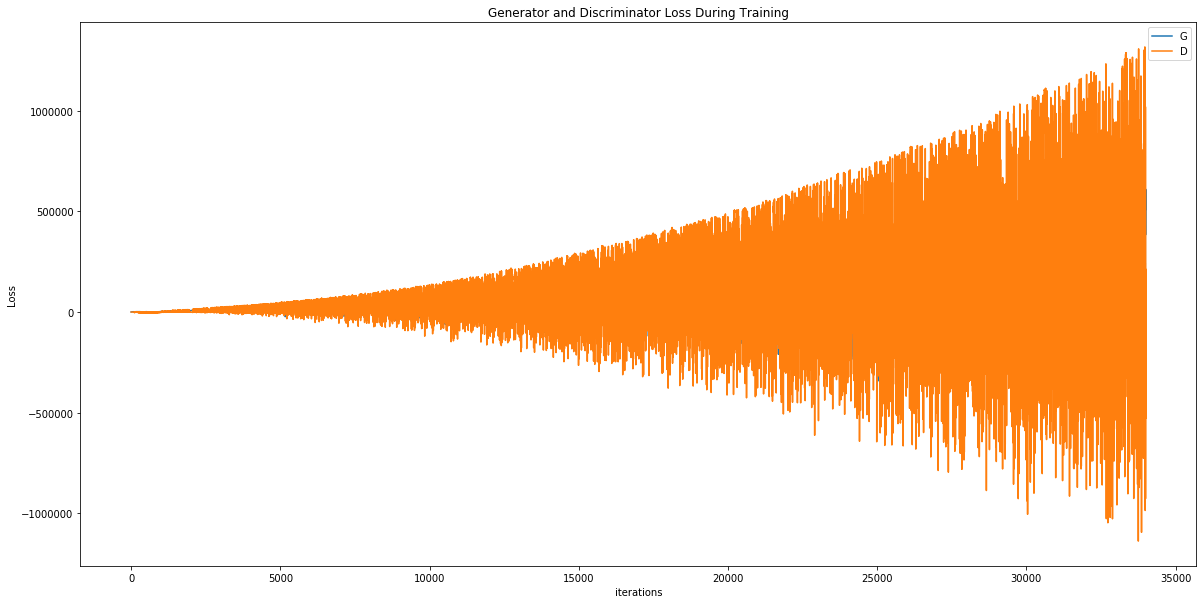

In [17]:
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(my_nnet_structure.neuronal_net_structure.G_losses,label="G")
plt.plot(my_nnet_structure.neuronal_net_structure.D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Real versus Fake images

In [12]:
%run ./UI/ClassWidgetRealFake.py

my_build_fake_real = cls_builder_real_vs_fake(dataloader, my_bop['nz'], my_nnet_structure.neuronal_net_structure, device, imshow)

my_build_fake_real.draw_buttons()

Output()

In [12]:
class gen_fakes:
    def __init__(self, NN, img_path):
        self._image = None
        self._pos = 0
        self._nn = NN
        self._img_path = img_path
        self._img_batch = None
        self._output = widgets.Output()
        self._iter = 0
        
    def _save_plot(self, b):
        os.system('mkdir {0}'.format(self._img_path))
        self._iter += 1
        vutils.save_image(self._image, '{0}/fake_samples_{1}.png'.format(self._img_path, self._iter))
    def _next_generation(self, b):
        with self._output:
            self._output.clear_output()
            self._pos = 0
            self._images = self._nn.get_fake_samples(False, True)
            self._img_batch = vutils.make_grid(self._images.cpu()[0:64])
            self._image = vutils.make_grid(self._images.cpu()[self._pos:(self._pos+1)])
            imshow(self._img_batch)
            imshow(self._image) 
    def _next_image(self, b):
        with self._output:
            if self._pos >= 64:
                self._pos = 0
            self._pos += 1
            self._output.clear_output()
            self._image = vutils.make_grid(self._images.cpu()[self._pos:(self._pos+1)])
            imshow(self._img_batch)
            imshow(self._image)  
    def draw_btn(self):
        btn_save = Button(description='save')
        btn_next_blop = Button(description='next batch')
        btn_next_img = Button(description='next image')
        ui = HBox([btn_next_blop, btn_next_img, btn_save])
        btn_next_blop.on_click(self._next_generation)
        btn_next_img.on_click(self._next_image)
        btn_save.on_click(self._save_plot)
        display(ui, self._output)

my_gen_fakes = gen_fakes(my_nnet_structure.neuronal_net_structure, './samples/')
my_gen_fakes.draw_btn()


Output()